# Log Analysis with Spark

### Outcomes:

* Install and apply Spark and PySpark tools to solve a problem
* Use Spark's MLlib for analysis of proxy logs and anomaly detection.
* Prepare, analyze and visualize real-world big data.


## Introduction

Log files are some of the most common big data that is best analyzed using a tool such as Spark. Many machines and devices produce a huge number of log that record events in time. In many situations, a programmer needs to parse these logs and load them into a dataframe in order to do some exploratory analytics.

In this Project, you will load a proxy log in order to have a look at the web access activity for a medium sized organization with thousands of users. The log will be provided and is named 16-6.txt which you will have to open and load using Spark, then perform various analytic operations and clustering using MLlib and k-Means, among others.


In [156]:
import re
import csv
import datetime
import warnings
warnings.filterwarnings("ignore")

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

The web proxy log was created by a SGOS BlueCoat Firewall. The log file starts with comments holding information as follows:

In [158]:
#Software: SGOS 5.2.3.9
#Version: 1.0
#Start-Date: 2008-06-16 13:00:00
#Date: 2008-06-12 16:00:31
#Fields: date time time-taken c-ip sc-status s-action sc-bytes cs-bytes cs-method cs-uri-scheme cs-host cs-uri-port cs-uri-path cs-uri-query cs-username cs-auth-group s-hierarchy s-supplier-name rs(Content-Type) cs(Referer) cs(User-Agent) sc-filter-result cs-categories x-virus-id s-ip
#Remark: 0707083160 "UOS-SG810" "192.168.2.21" "main"


The following is an example log entry:

    2008-06-16 13:00:00 351 192.168.39.53 200 TCP_REFRESH_MISS 32418 725 GET http www.dinamalar.com 80 /dfonts/SHREE0803.eot - - - DIRECT www.dinamalar.com application/octet-stream http://www.dinamalar.com/ "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1)" OBSERVED "News/Media" - 192.168.2.21
    

**Task 1.** Read all entries in the weblog into a dataframe 

The first task is to use spark to read all of the data from the .txt log file into a Spark dataframe. Below you will find a sample regular expression that can scan a line and break it down into its components. You can use Spark to map this over the lines of the file and then transfer it into a dataframe.

Or you can use the methods that load data from a file, and just determine what are the delimiters. You don't need to use this function or code. This is just an illustration of the structure of the data.

In [159]:
SGS_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) (\S+) (\S+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) "(\w+)" (\w+) "(\w+)" (\w+) (\w+)'

def parse_sgs_log_line(logline):
    match = re.search(SGS_ACCESS_LOG_PATTERN, logline)
    if match is None:
        print("Invalid logline: %s" % logline)
    else:
        print(match.group(1),match.group(2),match.group(3))

headings = ['date', 'time', 'time_taken', 'c_ip', 'sc_status', 's_action', 'sc_bytes', 'cs_bytes', 'cs_method', 'cs_uri_scheme', 'cs_host', 'cs_uri_port', 'cs_uri_path', 'cs_uri_query', 'cs_username', 'cs_auth_group', 's_hierarchy', 's_supplier_name', 'rs_Content_Type', 'cs_Referer', 'cs_User_Agent', 'sc_filter_result', 'cs-categories', 'x_virus_id', 's_ip']

The following is a sample Python code to use the function and regular expression above to scan the first 20 lines in the file. However, this does not use the power of Spark. If you want you can use the Map operation to perform the same thing on the file and create a Dataframe with the scanned information.

In [160]:
logfilename = '16-6.txt'

i=0
with open(logfilename, errors='ignore') as f:
    logreader = csv.reader(f, delimiter=' ', quotechar='\"') #delimiters and quotes in the proxy log file
    for item in logreader:
        if (item[0][0]!='#'):
            for j in range(25):
                print(j,':',item[j])
        i+=1
        if (i>10):
            break


0 : 2008-06-16
1 : 13:00:00
2 : 351
3 : 192.168.39.53
4 : 200
5 : TCP_REFRESH_MISS
6 : 32418
7 : 725
8 : GET
9 : http
10 : www.dinamalar.com
11 : 80
12 : /dfonts/SHREE0803.eot
13 : -
14 : -
15 : -
16 : DIRECT
17 : www.dinamalar.com
18 : application/octet-stream
19 : http://www.dinamalar.com/
20 : Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1)
21 : OBSERVED
22 : News/Media
23 : -
24 : 192.168.2.21
0 : 2008-06-16
1 : 13:00:00
2 : 440
3 : 192.168.105.99
4 : 200
5 : TCP_NC_MISS
6 : 1000
7 : 531
8 : GET
9 : http
10 : acvs.mediaonenetwork.net
11 : 80
12 : /client/acv211.js
13 : -
14 : -
15 : -
16 : DIRECT
17 : acvs.mediaonenetwork.net
18 : application/x-javascript
19 : http://msn.co.nz/
20 : Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; SLCC1; .NET CLR 2.0.50727; .NET CLR 3.0.04506; InfoPath.2)
21 : OBSERVED
22 : Web Advertisements
23 : -
24 : 192.168.2.21
0 : 2008-06-16
1 : 13:00:00
2 : 803
3 : 192.168.114.169
4 : 302
5 : TCP_NC_MISS
6 : 322
7 : 248
8 : GET
9 : http
10 : dl.fr

In [161]:
SGS_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) (\S+) (\w+) (\w+) (\w+) (\w+) (\w+) (\w+) (\S+) (\w+) (\S+) (\S+) (\S+) (\S+) (\w+) (\S+) (\S+) (\S+) "(.*?)" (\S+) "(.*?)" (\S+) (\S+)'

def parse_sgs_log_line(logline):
    if logline is None:
        print('empty logline')
        return null_record
    else:
        match = re.search(SGS_ACCESS_LOG_PATTERN, str(logline))
        if match is None:
            print("Invalid logline: %s" % logline)
            return null_record
        else:
            #return (match.group(1),match.group(2),match.group(3))
            return re.findall(SGS_ACCESS_LOG_PATTERN, str(logline))[0]

null_record = (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
headings = ['date', 'time', 'time_taken', 'c_ip', 'sc_status', 's_action', 'sc_bytes', 'cs_bytes', 'cs_method', 'cs_uri_scheme', 'cs_host', 'cs_uri_port', 'cs_uri_path', 'cs_uri_query', 'cs_username', 'cs_auth_group', 's_hierarchy', 's_supplier_name', 'rs_Content_Type', 'cs_Referer', 'cs_User_Agent', 'sc_filter_result', 'cs-categories', 'x_virus_id', 's_ip']

In [162]:
headings

['date',
 'time',
 'time_taken',
 'c_ip',
 'sc_status',
 's_action',
 'sc_bytes',
 'cs_bytes',
 'cs_method',
 'cs_uri_scheme',
 'cs_host',
 'cs_uri_port',
 'cs_uri_path',
 'cs_uri_query',
 'cs_username',
 'cs_auth_group',
 's_hierarchy',
 's_supplier_name',
 'rs_Content_Type',
 'cs_Referer',
 'cs_User_Agent',
 'sc_filter_result',
 'cs-categories',
 'x_virus_id',
 's_ip']

In [163]:
!pip install --default-timeout=300 pyspark


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [165]:
import pyspark
from pyspark.sql import *
import pyspark.sql.functions as sqlF

This is an example of reading the file using the spark.read method into a dataframe.

In [10]:
#sc = pyspark.SparkContext("local[*]")
spark = SparkSession.builder.appName('Practice3').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/01 12:04:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/01 12:04:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [166]:
input_file = '16-6.txt'

df_dataraw = spark.read.option('delimiter',' ').option('quote','\"').option('header',True).text(input_file)
df_dataraw_clean = df_dataraw.filter("value NOT LIKE '#%'")
df_dataraw_clean = df_dataraw_clean.filter("value != ''")
df_dataraw_clean = df_dataraw_clean.na.drop()
df_dataraw_clean.count()

3377335

23/12/01 14:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1463.6 KiB


### Data pre-processing


- spliting the values and columns from the raw data above
- convert columns to apprpriate datatypes
- checking for missing values if there are any

**Task 2.** Perform data cleansing and write any assumptions you made in the notes. Use the data to visualize the amount of activity in every hour of the day. Use a chart to do so after aggregating the information. 

In [168]:
from pyspark.sql.functions import split, col,hour,count
from pyspark.sql.types import TimestampType

df_preprocessed = df_dataraw_clean.select(
    split(col("value"), " ").alias("split_columns")
).select(
    *[col("split_columns")[i].alias(headings[i]) for i in range(len(headings))]
)

In [169]:
df_preprocessed = df_preprocessed.withColumn("date", col("date").cast(TimestampType()))

In [170]:
df_preprocessed = df_preprocessed.na.drop()

In [171]:
columns_to_display = ["date", "time", "time_taken", "c_ip", "sc_status",'s_action']
df_preprocessed.select(columns_to_display).show(5)

+-------------------+--------+----------+---------------+---------+----------------+
|               date|    time|time_taken|           c_ip|sc_status|        s_action|
+-------------------+--------+----------+---------------+---------+----------------+
|2008-06-16 00:00:00|13:00:00|       351|  192.168.39.53|      200|TCP_REFRESH_MISS|
|2008-06-16 00:00:00|13:00:00|       440| 192.168.105.99|      200|     TCP_NC_MISS|
|2008-06-16 00:00:00|13:00:00|       803|192.168.114.169|      302|     TCP_NC_MISS|
|2008-06-16 00:00:00|13:00:00|       402| 192.168.54.105|      200|        TCP_MISS|
|2008-06-16 00:00:00|13:00:00|         1| 192.168.105.99|      304|         TCP_HIT|
+-------------------+--------+----------+---------------+---------+----------------+
only showing top 5 rows



### assumtions about the data columns in the dataframe 

- date: This column appears to represent the date of the activity in the format 'YYYY-MM-DD'. The time component seems to be set to midnight for all entries.

- time: This column seems to represent the time of the day in the format 'HH:mm:ss'. However, in the provided data, all entries have the same time '13:00:00', which might be a placeholder or default value. If the time is indeed constant for all entries, it might not provide useful information for analysis.

- time_taken: This column could represent the time taken for the activity, possibly in milliseconds. The values seem to vary, suggesting different durations for different activities.

- c_ip: This column likely represents the client IP address involved in the activity. Each entry appears to be an IPv4 address.

- sc_status: This column represents the HTTP status code returned by the server. For example, '200' indicates a successful response, '302' is a redirection, and '304' is a not modified response.

- s_action: This column might represent the action taken during the activity. Possible values include 'TCP_REFRESH_MISS', 'TCP_NC_MISS', 'TCP_NC_MISS', and 'TCP_HIT'. These values could be related to cache handling or request/response handling.

### Visualization

In [74]:
# WE need to aggregate the activity by date and time
df_activity_over_time = df_preprocessed.groupBy(["date", "time"]).agg(count("*").alias("activity_count")).orderBy("date")
df_pandas_activity = df_activity_over_time.toPandas()


In [82]:
df_pandas_activity['datetime'] = df_pandas_activity['date'] + pd.to_timedelta(df_pandas_activity['time'])
df_pandas_activity = df_pandas_activity.sort_values(by='datetime')

In [83]:
df_pandas_activity

,date,time,activity_count,datetime
37778,2008-06-16,13:00:00,7,2008-06-16 13:00:00
14040,2008-06-16,13:00:01,53,2008-06-16 13:00:01
8979,2008-06-16,13:00:02,36,2008-06-16 13:00:02
32928,2008-06-16,13:00:03,25,2008-06-16 13:00:03
20890,2008-06-16,13:00:04,19,2008-06-16 13:00:04
...,...,...,...,...
83051,2008-06-17,12:59:56,62,2008-06-17 12:59:56
83912,2008-06-17,12:59:57,53,2008-06-17 12:59:57
83372,2008-06-17,12:59:58,63,2008-06-17 12:59:58
83688,2008-06-17,12:59:59,68,2008-06-17 12:59:59


#### Total number of activities in the specific dateA

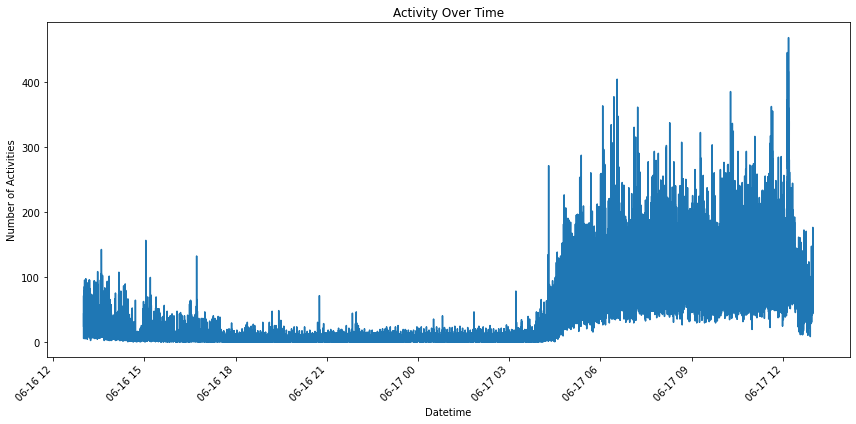

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the activity over time.
plt.figure(figsize=(12, 6))
plt.plot(list(df_pandas_activity['datetime']), list(df_pandas_activity['activity_count']), linestyle='-')
plt.title("Activity Over Time")
plt.xlabel("Datetime")
plt.ylabel("Number of Activities")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Task 3.**	Perform exploratory data analysis on the loaded data by obtaining the following statistics and drawing them in charts:

1. What is the 10 most accessed websites?

1. What are the top 10 domains accessed by the local machines?

1. What is the 10 most accessed types of requests?

1. What is the percentage of valid vs invalid requests?

1. What is the popular browsers used by uses?

1. What is the top 20 ip addresses with the highest traffic in this day?


#### 1) What is the 10 most accessed websites?

Groupin the data by 'cs_host' and count the occurrences will let us find the top accessed websites. 

In [87]:
from pyspark.sql.functions import col, desc

df_website_counts = df_preprocessed.groupBy("cs_host").count()
df_top_websites = df_website_counts.orderBy(desc("count"))

df_top_10_websites = df_top_websites.limit(10)
df_top_10_websites.show()

+--------------------+------+
|             cs_host| count|
+--------------------+------+
|  master.dyngate.com|128722|
|          dl.free.fr|127521|
|     mail.google.com| 68835|
|     tbn0.google.com| 44855|
| www.alwasatnews.com| 38074|
|www.google-analyt...| 36054|
|   www.gulfdreem.com| 32164|
|      www.alayam.com| 31436|
|pagead2.googlesyn...| 29785|
|                   -| 29538|
+--------------------+------+



#### 2) What are the top 10 domains accessed by the local machines?

Grouping the data based on c_ip column of the our processed dataframe

In [90]:
df_local_domains = df_preprocessed.filter(col("c_ip").startswith("192.168."))
df_domain_counts = df_local_domains.groupBy("c_ip").count()
df_top_domains = df_domain_counts.orderBy(desc("count"))

df_top_10_domains = df_top_domains.limit(10)
df_top_10_domains.show()

+---------------+------+
|           c_ip| count|
+---------------+------+
|   192.168.2.20|171913|
|192.168.114.169|131722|
|192.168.226.236|129579|
|192.168.114.160|102002|
|  192.168.54.37| 53887|
| 192.168.108.40| 30602|
| 192.168.227.40| 23551|
|  192.168.94.67| 21090|
|192.168.114.170| 19972|
|  192.168.85.89| 18576|
+---------------+------+



#### 3) What is the 10 most accessed types of requests?

Groupin the data by 'cs_method' and count the occurrences

In [91]:

df_request_counts = df_preprocessed.groupBy("cs_method").count()
df_top_requests = df_request_counts.orderBy(desc("count"))

df_top_10_requests = df_top_requests.limit(10)
df_top_10_requests.show()

+---------+-------+
|cs_method|  count|
+---------+-------+
|      GET|2998967|
|  CONNECT| 180099|
|     POST| 146537|
|  unknown|  28626|
|     HEAD|  14435|
| PROPFIND|   5752|
|     OPEN|    981|
|  OPTIONS|    384|
|PROPPATCH|    275|
| REGISTER|     45|
+---------+-------+



#### 4) What is the percentage of valid vs invalid requests?


we will first take the total number of requests in the dataframe then we are going to Count the number of valid requests (assuming status code 200 represents valid requests)

In [93]:

total_requests = df_preprocessed.count()
valid_requests = df_preprocessed.filter(col("sc_status") == 200).count()

invalid_requests = total_requests - valid_requests

perc_valid = (valid_requests / total_requests) * 100
perc_invalid = (invalid_requests / total_requests) * 100

print(f"Percentage of Valid Requests: {perc_valid:.2f}%")
print(f"Percentage of Invalid Requests: {perc_invalid:.2f}%")

Percentage of Valid Requests: 65.88%
Percentage of Invalid Requests: 34.12%


#### 5) What is the popular browsers used by uses?
To get the top populat browsers used by users we need to Group by 'cs_User_Agent' and count the total occurrences of each user agent

In [94]:
df_browser_counts = df_preprocessed.groupBy("cs_User_Agent").count()
df_top_browsers = df_browser_counts.orderBy(desc("count"))

df_top_10_browsers = df_top_browsers.limit(10)
df_top_10_browsers.show(truncate=False)

+--------------------------------------------+-------+
|cs_User_Agent                               |count  |
+--------------------------------------------+-------+
|"Mozilla/4.0                                |2770857|
|"Mozilla/5.0                                |178615 |
|-                                           |168125 |
|"Smc"                                       |54473  |
|"Microsoft                                  |38895  |
|"Windows-Update-Agent"                      |19583  |
|"VCSoapClient"                              |16692  |
|"Internet                                   |10780  |
|"Opera/9.50                                 |10634  |
|"GoogleEarth/4.3.7204.0836(Windows;Microsoft|8339   |
+--------------------------------------------+-------+



#### 6) What is the top 20 ip addresses with the highest traffic in this day?

- select the specific date and then filter the column of dataset for that specific date
- The compute the sum of total traffic for each s_ip on that particular date

In [96]:
specific_date = "2008-06-16"
df_specific_date = df_preprocessed.filter(col("date") == specific_date)

df_traffic_per_ip = df_specific_date.groupBy("s_ip").agg({"sc_bytes": "sum"}).withColumnRenamed("sum(sc_bytes)", "total_traffic")

df_top_ips = df_traffic_per_ip.orderBy(desc("total_traffic"))

df_top_20_ips = df_top_ips.limit(20)
df_top_20_ips.show(truncate=False)

+------------------------------+-------------+
|s_ip                          |total_traffic|
+------------------------------+-------------+
|Windows                       |5.030909402E9|
|192.168.2.21                  |3.686169819E9|
|-                             |9.63862251E8 |
|192.168.2.12                  |1.06845779E8 |
|U;                            |6.6999718E7  |
|NT                            |2.9759495E7  |
|"Religion"                    |2.6385151E7  |
|"News/Media"                  |8686517.0    |
|Groups"                       |6932407.0    |
|"Computers/Internet"          |6261198.0    |
|"Arts/Entertainment"          |5276912.0    |
|32bit;                        |5069823.0    |
|"Software                     |3240483.0    |
|OBSERVED                      |2861695.0    |
|"Search                       |2364024.0    |
|"Computers/Internet;Streaming |1733305.0    |
|Patches"                      |1520807.0    |
|Mac                           |1461676.0    |
|Effects/Priv

**Task 4.** Perform clustering on the IP addresses based on the websites they access. To do so you will have to transform this information into a vector and then use k-means to find clusers for k=5,6,7,8,9, and 10.

A lot will depend on how you can represent the web domains that are being contacted by the internal end points (IP addresses). You can always create a list of the websites accessed during this whole day and represent them by numbers. Then use these numbers to identify which websites were accessed in a 0/1 list for each of the internal endpoints. This will be of course a big sparse list.

Calculate the Silhouette Index for each cluster and choose the best k. 


#### Clustering processing steps
Following steps were included in order to genrate clusters for Ip address

- Slecting the required columns from the full dataset
- Creating the list of unique websites accessed
- Maping the website names to indices
- Creating a sparse vector representation for each IP address
- Stdandrizing the vectors using standards scaler
- Checking Kmeans model on 5 different values of k 
- Choosing best k values using best silhouette score

In [172]:
# Select relevant columns
selected_columns = ['c_ip', 'cs_host']
df_selected = df_preprocessed.select(selected_columns)

In [173]:
# Creating a list of unique websites accessed
websites = df_selected.select('cs_host').distinct().rdd.flatMap(lambda x: x).collect()

In [174]:
# Create a mapping of website names to indices
from pyspark.ml.feature import StringIndexer, VectorAssembler
website_indexer = StringIndexer(inputCol='cs_host', outputCol='website_index')
df_indexed = df_indexed.withColumn('website_index', df_indexed['website_index'].cast('double'))

In [175]:
df_indexed.show()

+---------------+--------------------+-------------+
|           c_ip|             cs_host|website_index|
+---------------+--------------------+-------------+
|  192.168.39.53|   www.dinamalar.com|        798.0|
| 192.168.105.99|acvs.mediaonenetw...|       5549.0|
|192.168.114.169|          dl.free.fr|          1.0|
| 192.168.54.105|       www.diino.com|        618.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        450.0|
| 192.168.105.99|           msn.co.nz|        

23/12/01 14:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1436.1 KiB


In [176]:
# Creating a sparse vector representation for each IP address
assembler = VectorAssembler(inputCols=['website_index'], outputCol='features')

df_vectorized = assembler.transform(df_indexed)
df_vectorized.show()

+---------------+--------------------+-------------+--------+
|           c_ip|             cs_host|website_index|features|
+---------------+--------------------+-------------+--------+
|  192.168.39.53|   www.dinamalar.com|        798.0| [798.0]|
| 192.168.105.99|acvs.mediaonenetw...|       5549.0|[5549.0]|
|192.168.114.169|          dl.free.fr|          1.0|   [1.0]|
| 192.168.54.105|       www.diino.com|        618.0| [618.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|
| 192.16

23/12/01 14:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1443.9 KiB


In [177]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df_vectorized)
df = scaler_model.transform(df_vectorized)

23/12/01 14:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1455.9 KiB
23/12/01 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1454.8 KiB


In [178]:
df.show()

+---------------+--------------------+-------------+--------+--------------------+
|           c_ip|             cs_host|website_index|features|     scaled_features|
+---------------+--------------------+-------------+--------+--------------------+
|  192.168.39.53|   www.dinamalar.com|        798.0| [798.0]|[0.2631589780203651]|
| 192.168.105.99|acvs.mediaonenetw...|       5549.0|[5549.0]|[1.8299112393922377]|
|192.168.114.169|          dl.free.fr|          1.0|   [1.0]|[3.29773155413991...|
| 192.168.54.105|       www.diino.com|        618.0| [618.0]|[0.20379981004584...|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|
| 19

23/12/01 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1448.9 KiB


In [180]:
from pyspark.ml.evaluation import ClusteringEvaluator
k_values = [5,6,7,8,9,10]
evaluator = ClusteringEvaluator()

best_k = None
best_silhouette = -1

for val in k_values:
    kmeans = KMeans(k=val, seed=42, featuresCol='scaled_features')
    model = kmeans.fit(df)
    silhouette = evaluator.evaluate(model.transform(df))
    print(f"Silhouette Index for k={val}: {silhouette}")

    if silhouette > best_silhouette:
        best_k = k
        best_silhouette = silhouette

23/12/01 14:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1467.9 KiB
23/12/01 14:35:20 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:35:25 WAR

Silhouette Index for k=5: 0.8873984244242376


23/12/01 14:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 14:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 14:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:40:13 WAR

Silhouette Index for k=6: 0.8707818179380322


23/12/01 14:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 14:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 14:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:43:25 WAR

Silhouette Index for k=7: 0.8804601442980905


23/12/01 14:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 14:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 14:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:46:39 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:46:39 WAR

Silhouette Index for k=8: 0.8604704055975566


23/12/01 14:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 14:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 14:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:55:32 WAR

Silhouette Index for k=9: 0.8617569652030707


23/12/01 14:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 14:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 14:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 14:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 14:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 14:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 14:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 14:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 14:58:37 WAR

Silhouette Index for k=10: 0.8611046732875876


#### Making clusters using best K

In [181]:
print(f"Best k: {best_k} Best silhouette Score: {best_silhouette}")

Best k: 5 Best silhouette Score: 0.8873984244242376


In [182]:
kmeans = KMeans(k=best_k, seed=42, featuresCol='scaled_features', predictionCol='cluster')
model = kmeans.fit(df)
predicted_clusters_df =model.transform(df)

23/12/01 15:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1467.9 KiB
23/12/01 15:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB
23/12/01 15:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1477.7 KiB
23/12/01 15:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB
23/12/01 15:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1479.0 KiB
23/12/01 15:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 15:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1479.4 KiB
23/12/01 15:02:17 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
23/12/01 15:02:17 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
23/12/01 15:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 15:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1479.6 KiB
23/12/01 15:02:19 WAR

In [183]:
predicted_clusters_df.show()

+---------------+--------------------+-------------+--------+--------------------+-------+
|           c_ip|             cs_host|website_index|features|     scaled_features|cluster|
+---------------+--------------------+-------------+--------+--------------------+-------+
|  192.168.39.53|   www.dinamalar.com|        798.0| [798.0]|[0.2631589780203651]|      1|
| 192.168.105.99|acvs.mediaonenetw...|       5549.0|[5549.0]|[1.8299112393922377]|      0|
|192.168.114.169|          dl.free.fr|          1.0|   [1.0]|[3.29773155413991...|      1|
| 192.168.54.105|       www.diino.com|        618.0| [618.0]|[0.20379981004584...|      1|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|      1|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|      1|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|      1|
| 192.168.105.99|           msn.co.nz|        450.0| [450.0]|[0.14839791993629...|      1|

23/12/01 15:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1462.6 KiB


**Task 5.** Write your conclusions and what lessons you learned from performing this project.

### Conclusion:

Following are some parts of analysis that we did in our project above which based on handling large datasets using pyspark. 

- **Data Cleansing and Preprocessing:** Describe the steps taken for data cleansing and preprocessing. Summarize key findings from exploratory data analysis (EDA).
- **Traffic Analysis:** Discuss the distribution of traffic over time.
- **Top Access Metrics:** Provide insights into the most accessed websites, domains, types of requests, etc.
- **Cluster Analysis Results:** Present the optimal number of clusters determined through silhouette analysis.

### Lessons Learned:



- **Data Quality and Cleaning:** Highlighted the importance of data quality and the impact on analysis. with the help of data cleaning stratigies like dopring null values, checking the data types concating different features in the data etc. 
- **Feature Engineering:** Reflect on the significance of feature engineering in creating meaningful variables.
- **Clustering Techniques:** learning how to make a choice of clustering technique and the rationale behind it.Evaluate the effectiveness of silhouette analysis in determining the optimal number of clusters.
- **Visualization and Communication:** Reflect on the effectiveness of data visualization in conveying insights.


